In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import jax.random as random
import pickle
import seaborn as sns 
from statannot import add_stat_annotation
import scipy.stats as stats
import umap
import tqdm
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt

## Set this to disable JAX from preallocating memory
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from datasets import *
from training_setup import *
from training import *
from utils import *
from analysis_utils import *

In [2]:
DATA_PATH="/media/sayalialatkar/T9/Sayali/UDSB/UDSB/BroadInstitute_Zebrafish/processed"
SAVE_PATH="./"
MODEL_PATH="/media/sayalialatkar/T9/Sayali/UDSB/UDSB/src_vae_fbsde/resultsv1.2/params/zebrafish"

In [3]:
df = pd.read_csv(f"{DATA_PATH}/zebrafish_cells_all_timepoints_2000genes.csv", index_col=0)
total_timepoints = len(df["time"].unique())
timepoint_map={k:v for k,v in zip(np.arange(total_timepoints), sorted(df["time"].unique()))}
rev_timepoint_map={k:v for k,v in zip(sorted(df["time"].unique()), np.arange(total_timepoints))}
df["time"] = df["time"].map(rev_timepoint_map)

train_tps_idx = [ 0.,  1.,  2.,  3.,  5.,  7.,  9., 10., 11.]
val_tps_idx = [4., 6., 8.]

train_tps = train_tps_idx
val_tps = val_tps_idx

timepoints_sorted =  sorted(df["time"].unique().tolist())
# timepoints_sorted  = sorted(train_tps + val_tps)
    
train_data = df[df["time"].isin(train_tps)].iloc[:,:]
val_data = df[df["time"].isin(val_tps)].iloc[:,:]

train_data.shape, val_data.shape, train_data["time"].unique(), val_data["time"].unique()

((23472, 2001),
 (15259, 2001),
 array([ 0,  1,  2,  3,  5,  7,  9, 10, 11]),
 array([4, 6, 8]))

In [4]:
z_score=False

if z_score:
    train_data = z_score_norm(train_data)
    val_data = z_score_norm(val_data)

In [6]:
train=False

vae_latent_dim=10
vae_enc_hidden_dim=vae_dec_hidden_dim=[256,128]
vae_input_dim=train_data.iloc[:,:-1].shape[-1]
t_dim=16
lr= 1e-3
vae_lr= 1e-3
ferryman_lr= 1e-3

dec_hidden_dim=200
td_sched = 2
vae_epochs=50
epochs=10   
num_sde=10
paths_reuse=5
steps_num=100
batch_size=256
vae_batch_size=64
ferryman_hidden_dim=64
death_importance_rate = 1
vae_t_dim=8
f_val=2

if train:
    
    train_dataset = Input_Dataset(x=train_data, meta=None, meta_celltype_column=None, splitting_births_frac=0.9,
                            steps_num=steps_num, val_split=False, death_importance_rate=death_importance_rate, f_val=f_val)

    ts = Training_Setup(dataset=train_dataset, dataset_name="Zebrafish", hidden_dim=[dec_hidden_dim,dec_hidden_dim,], 
                        dec_hidden_size=[dec_hidden_dim, dec_hidden_dim, 1],vae_epochs=vae_epochs, 
                        epochs=epochs,  num_sde=num_sde, paths_reuse=paths_reuse, reality_coefficient=0.2, 
                        ipf_mask_dead=True, t_dim=t_dim, batch_size=batch_size, vae_batch_size=vae_batch_size,
                        vae_input_dim=vae_input_dim, vae_enc_hidden_dim=vae_enc_hidden_dim, vae_dec_hidden_dim=vae_dec_hidden_dim,
                        vae_latent_dim=vae_latent_dim, ferryman_hidden_dim=[ferryman_hidden_dim, ferryman_hidden_dim,])

    tr = Trainer(dataset=train_dataset, ts=ts,key=random.PRNGKey(0), lr=lr, vae_lr=vae_lr, ferryman_lr=ferryman_lr, ferryman_coeff=1)

    tr_model = tr.train(td_schedule=[1]*td_sched, project_name="Zebrafish")

    train_recon, train_latent, val_recon, val_latent = get_model_latents(train_data, val_data, ts, tr_model)


else:
    train_dataset = Input_Dataset(x=train_data, meta=None, meta_celltype_column=None, splitting_births_frac=0.9,
                            steps_num=steps_num, val_split=False, death_importance_rate=death_importance_rate,f_val=f_val)

    ts = Training_Setup(dataset=train_dataset, dataset_name="Zebrafish", hidden_dim=[dec_hidden_dim,dec_hidden_dim,], 
                        dec_hidden_size=[dec_hidden_dim, dec_hidden_dim, 1],vae_epochs=vae_epochs, 
                        epochs=epochs,  num_sde=num_sde, paths_reuse=paths_reuse, reality_coefficient=0.2, 
                        ipf_mask_dead=True, t_dim=t_dim, batch_size=batch_size, vae_batch_size=vae_batch_size,
                        vae_input_dim=vae_input_dim, vae_enc_hidden_dim=vae_enc_hidden_dim, vae_dec_hidden_dim=vae_dec_hidden_dim,
                        vae_latent_dim=vae_latent_dim, ferryman_hidden_dim=[ferryman_hidden_dim, ferryman_hidden_dim,])

    tr = Trainer(dataset=train_dataset, ts=ts,key=random.PRNGKey(0), lr=lr, vae_lr=vae_lr, ferryman_lr=ferryman_lr, ferryman_coeff=1)
    with open(f"{MODEL_PATH}/train_zebrafish_4_6_8_heldout.pkl","rb") as f:
        model_params = pickle.load(f)
        
    tr_model = tr
    tr_model.vae_params = model_params["vae_params"]
    tr_model.training_setup.state[1]["forward"] = model_params["forward"]
    tr_model.training_setup.state[1]["backward"] = model_params["backward"]
    tr_model.training_setup.state[1]["ferryman"] = model_params["ferryman"]
    train_recon, train_latent, val_recon, val_latent = get_model_latents(train_data, val_data, ts, tr_model)
    train_dataset.update_data_info(train_latent, None)
    ts.sde.killer = train_dataset.killing_function()

In [19]:
_tps= sorted(train_tps+val_tps)
predictions, predictions_all = get_predictions(train_data, val_data, train_tps, val_tps,train_dataset,train_latent,_tps,tr_model,
                                      ts,vae_input_dim, vae_dec_hidden_dim,vae_latent_dim)
simulations = predictions["simulations"]
for t in val_tps:
    perf_df = get_metrics(simulations, val_data[val_data["time"]==t].values[:,:-1],t)
    print (perf_df.mean(), perf_df.std())

w2    32.071415
dtype: float64 w2    0.314394
dtype: float64
w2    29.213394
dtype: float64 w2    0.116507
dtype: float64
w2    31.576568
dtype: float64 w2    0.198307
dtype: float64


### Result analyses

1. Visualize VAE latents and reconstructed cell

In [8]:
mapper = umap.UMAP().fit(val_latent.values[:,:-1])
val_pred_latent = mapper.transform(val_latent.values[:,:-1])

mapper = umap.UMAP().fit(val_data.values[:,:-1])
val_preg_orig = mapper.transform(val_data.values[:,:-1])
val_pred_logits = mapper.transform(val_recon.values[:,:-1])

Text(0.5, 1.0, 'held-out data: reconstructed gene expression')

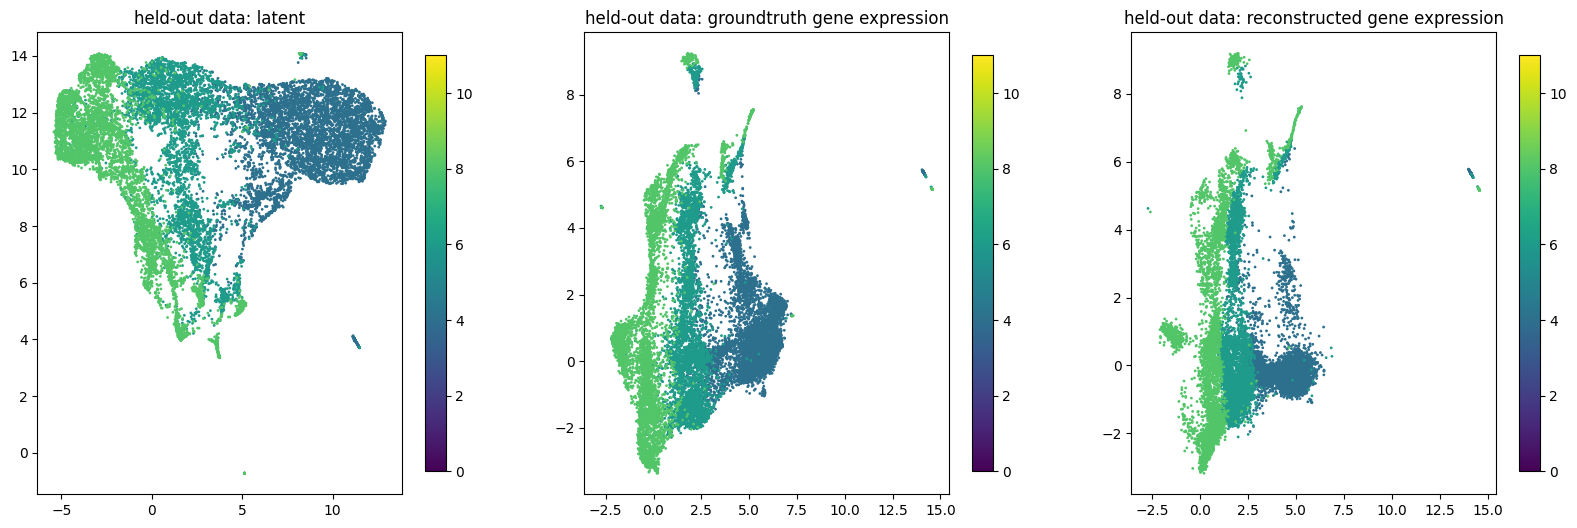

In [9]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (20, 6))

sax1 = ax1.scatter(val_pred_latent[:,0], val_pred_latent[:,1], s = 1, c = val_latent.values[:,-1], vmin = min(timepoints_sorted), vmax = max(timepoints_sorted),cmap="viridis")
plt.colorbar(sax1, shrink = 0.9)
ax1.set_title("held-out data: latent")

sax2 = ax2.scatter(val_preg_orig[:,0], val_preg_orig[:,1], s = 1, c = val_data.values[:,-1], vmin = min(timepoints_sorted), vmax = max(timepoints_sorted),cmap="viridis")
plt.colorbar(sax2, shrink = 0.9)
ax2.set_title("held-out data: groundtruth gene expression")

sax3 = ax3.scatter(val_pred_logits[:,0], val_pred_logits[:,1], s = 1, c = val_recon.values[:,-1], vmin = min(timepoints_sorted), vmax = max(timepoints_sorted),cmap="viridis")
plt.colorbar(sax3, shrink = 0.9)
ax3.set_title("held-out data: reconstructed gene expression")

2. Relative cell population changes 

In [11]:
pred_trajectories, pred_trajectories_alive, timepoints, timepoints_alive, statuses, birth_statuses = get_latent_trajectories(train_dataset,train_latent, timepoints_sorted, tr_model, ts, max_size=2000,t_0_orig=train_tps[0])
all_mass = df["time"].value_counts().sort_index().values

predicted_status = np.array([(statuses[int(tr_model.dataset.cells_time(timepoints_sorted[i])*steps_num)].sum().item())/(statuses[int(tr_model.dataset.cells_time(timepoints_sorted[i-1])*steps_num)].sum().item()) for i in range(1,len(timepoints_sorted))])
predicted_status_norm = (predicted_status - predicted_status.min())/(predicted_status.max() - predicted_status.min())
groundtruth_status_norm = all_mass[1:]/all_mass[:-1]
groundtruth_status_norm = (groundtruth_status_norm - groundtruth_status_norm.min())/(groundtruth_status_norm.max()-groundtruth_status_norm.min())

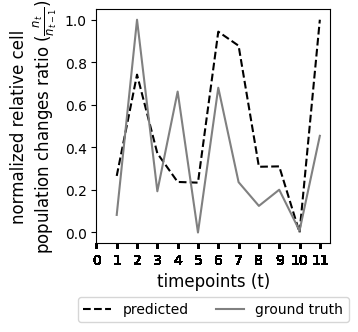

In [12]:
fig, ax = plt.subplots(figsize = (3.5, 3.5))

plt.plot(list(timepoint_map.keys())[1:], predicted_status_norm,label="predicted", color="black", ls='--')
plt.plot(list(timepoint_map.keys())[1:], groundtruth_status_norm, label="ground truth", color="grey")

plt.xticks(timepoints)
plt.xlabel("timepoints (t)", fontdict={"size":12})
plt.ylabel(f"normalized relative cell\npopulation changes ratio "+r"($\frac{n_{t}}{n_{t-1}})$", fontdict={"size":12})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.tight_layout()
# plt.savefig(f"{SAVE_PATH}/relative_cell_population_changes_zebrafish.png", dpi=300, bbox_inches='tight')
plt.show()

3. Reconstructed trajectories

In [13]:
# for held-out timepoints

pred_trajectories_alive_w_time = pd.DataFrame(pred_trajectories_alive)
pred_trajectories_alive_w_time["time"] = timepoints_alive
test_trajs = get_test_trajs(pred_trajectories_alive_w_time, val_data["time"].to_list())

pred_trajectories_w_time = pd.DataFrame(pred_trajectories)
pred_trajectories_w_time["time"] = timepoints
test_trajs_all = get_test_trajs(pred_trajectories_w_time, val_data["time"].to_list())

In [14]:

recon_data = get_reconstructed_trajectory(pred_trajectories_alive, val_data, vae_input_dim, vae_dec_hidden_dim,vae_latent_dim, tr_model, timepoints_alive)

mapper = umap.UMAP(random_state=42, n_components=2)
all_true_umap = mapper.fit_transform(pd.concat([train_data, val_data]).iloc[:,:-1].values)
val_true_umap = mapper.transform(val_data.iloc[:,:-1].values)

val_recon_w_time = pd.DataFrame(recon_data)
val_recon_w_time["time"] = timepoints_alive
test_recon_trajs = get_test_trajs(val_recon_w_time, val_data["time"].to_list())
pred_recon_umap = mapper.transform(test_recon_trajs.iloc[:,:-1].values)

pred_recon_all_umap = mapper.transform(val_recon_w_time.iloc[:,:-1].values)

Text(0.5, 1.0, 'reconstructed trajectory')

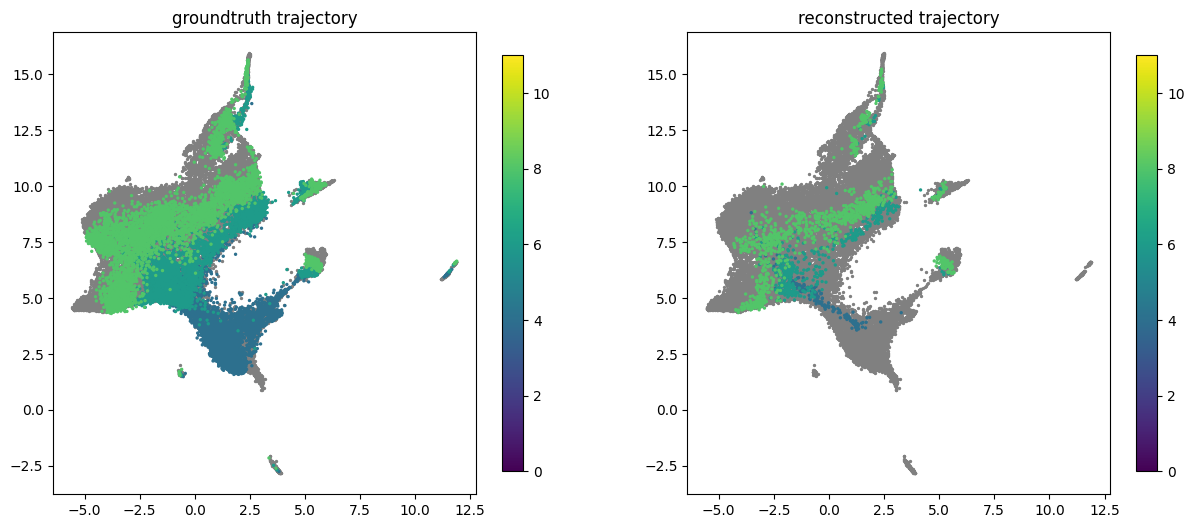

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15, 6))

ax1.scatter(all_true_umap[:,0], all_true_umap[:,1], s = 2, c="grey")
sax1 = ax1.scatter(val_true_umap[:,0], val_true_umap[:,1], s = 2, c = val_data.iloc[:,-1], vmin = min(timepoints_sorted), vmax = max(timepoints_sorted),cmap="viridis")
plt.colorbar(sax1, shrink = 0.9)
ax1.set_title("groundtruth trajectory")

ax2.scatter(all_true_umap[:,0], all_true_umap[:,1], s = 2, c="grey")
sax2 = ax2.scatter(pred_recon_umap[:,0], pred_recon_umap[:,1], s = 2, c = test_recon_trajs.iloc[:,-1], vmin = min(timepoints_sorted), vmax = max(timepoints_sorted),cmap="viridis")
plt.colorbar(sax2, shrink = 0.9) 
ax2.set_title("reconstructed trajectory")

4. Visualize cellular drift

In [16]:
train_val_latent = pd.concat([train_latent, val_latent])
all_true_umap_df =  pd.DataFrame(all_true_umap)
all_true_umap_df["time"] = pd.concat([train_data, val_data]).iloc[:,-1].values

params = tr.training_setup.state[1]
score = broadcast(lambda model, params: partial(tr.training_setup.score(model), params), tr.training_setup.model, params)
params_ferryman = tr_model.training_setup.state[1][FERRYMAN]
eval_ferryman= partial(tr_model.training_setup.ferryman.apply, params=params_ferryman, direction=FORWARD)

dec = hk.transform(lambda z: Decoder(output_shape=vae_input_dim, hidden_size=vae_dec_hidden_dim)(z))
rng_seq = hk.PRNGSequence(1)
dec_init_params = dec.init(next(rng_seq), z=np.zeros((val_data.shape[0], vae_latent_dim+vae_t_dim)))

for key in tr_model.vae_params.keys():
    if "dec" in key:
        dec_init_params[key.split("~/")[1]] = tr_model.vae_params[key]

In [17]:
n=12
color = cm.rainbow(np.linspace(0, 1, n))
color_dict = {k:v for k,v in zip(timepoints_sorted, color)}

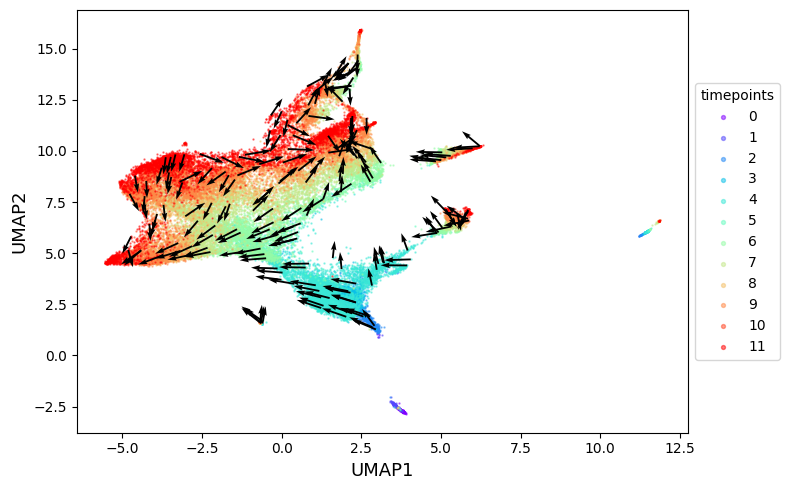

In [18]:
c_l = all_true_umap_df["time"].to_list() 
xg = 10
yg = 20
xgrid = np.linspace(int(all_true_umap[:,0].min()), int(all_true_umap[:,0].max()), xg)
ygrid = np.linspace(int(all_true_umap[:,1].min()), int(all_true_umap[:,1].max()), yg)

fig, ax = plt.subplots(figsize = (8,5))
for n,g in all_true_umap_df.groupby("time"):
    ax.scatter(g[0].values, g[1].values, s = 0.5, label=n, c=color_dict[n], alpha=0.5)#'gray')
plt.legend(markerscale=4, loc='center left', bbox_to_anchor=(1, 0.5), title="timepoints")


for xi in range(xg-1): 
    for yi in range(yg-1): 
        
        xmin, xmax = xgrid[xi], xgrid[xi+1]
        ymin, ymax = ygrid[yi], ygrid[yi+1]
    
        in_x = (all_true_umap[:,0] > xmin) & (all_true_umap[:,0] < xmax)
        in_y = (all_true_umap[:,1] > ymin) & (all_true_umap[:,1] < ymax)
        in_box = in_x & in_y    
        
        if in_box.sum() > 3: 
            ix = np.random.choice(np.where(in_box)[0], max(3, int(in_box.sum() * 0.002)))

            xv = train_val_latent.iloc[:,:-1].values[ix,:]
            xv_t = train_val_latent.iloc[:,-1].values[ix]

            xv_t = np.array([train_dataset.cells_time(xv_t_i) for xv_t_i in xv_t])
            curr_score_t=[]
            for xv_t_i, xv_i in zip(xv_t,xv):
                curr_score_t.append(score["forward"](random.PRNGKey(0), xv_t_i,xv_i.reshape(1,vae_latent_dim))/ts.sde.g(xv_t_i,xv_i))
            curr_score = np.vstack(curr_score_t)

            xv = xv + curr_score

            t_emb = get_timestep_embedding( train_val_latent.iloc[:,-1].values[ix], vae_t_dim)
            pred_traj_t = jnp.concatenate((xv,t_emb),-1)

            xv = dec.apply(dec_init_params, None, pred_traj_t)
            xv = mapper.transform(xv) - all_true_umap[ix,:]
            xv = xv / np.linalg.norm(xv, axis = 1)[:,np.newaxis]

            ax.quiver(all_true_umap[ix,0], all_true_umap[ix,1], xv[:,0], xv[:,1], scale = 1.2, scale_units = 'xy', 
                width = .003)
ax.set_xlabel('UMAP1', fontdict={"size":13})
ax.set_ylabel('UMAP2', fontdict={"size":13})
plt.tight_layout()
# plt.savefig(f"{SAVE_PATH}/cell_drift_original_space.png", dpi=300)
plt.show()

5. Identify drift-genes

In [12]:
dec = hk.transform(lambda z: Decoder(output_shape=vae_input_dim, hidden_size=vae_dec_hidden_dim)(z))
rng_seq = hk.PRNGSequence(1)
dec_init_params = dec.init(next(rng_seq), z=np.zeros((val_data.shape[0], vae_latent_dim+vae_t_dim)))

for key in tr_model.vae_params.keys():
    if "dec" in key:
        dec_init_params[key.split("~/")[1]] = tr_model.vae_params[key]
        
def decoder_output(z):
    recon_data = dec.apply(dec_init_params, None, z)
    return recon_data

params = tr.training_setup.state[1]
score = broadcast(lambda model, params: partial(tr.training_setup.score(model), params), tr.training_setup.model, params)

top_n=20
drift_genes = {}
shuffled_drift_genes={}

for int_t in pred_trajectories_w_time["time"].unique():

    print ("time:", int_t)
    shuffled_drift_genes[int_t] = []

    z_traj = pred_trajectories_w_time[pred_trajectories_w_time["time"]==int_t].values[:,:-1]
    t_emb = get_timestep_embedding(pred_trajectories_w_time[pred_trajectories_w_time["time"]==int_t].values[:,-1], vae_t_dim)
    pred_traj_t = jnp.concatenate((z_traj,t_emb),-1)
    z_score = score["forward"](random.PRNGKey(0), train_dataset.cells_time(int_t), z_traj)
    z_score_t = jnp.concatenate((z_score, t_emb), -1)

    #print ("computing jacobian-vector product (jvp)")
    output, jvp = jax.jvp(decoder_output, (pred_traj_t,), (z_score_t,))
    jvp_df = pd.DataFrame(jvp, columns=train_data.columns[:-1])

    # create null distribution by shuffling cells in latent space
    for i in range(100):
        z_traj_shuffled = jax.random.permutation(random.PRNGKey(i), z_traj)
        z_score_shuffled = score["forward"](random.PRNGKey(0), train_dataset.cells_time(int_t), z_traj_shuffled)
        z_score_shuffled_t = jnp.concatenate((z_score_shuffled, t_emb), -1)
        output_shuffled, jvp_shuffled = jax.jvp(decoder_output, (pred_traj_t,), (z_score_shuffled_t,))
        jvp_shuffled_df = pd.DataFrame(jvp_shuffled, columns=train_data.columns[:-1])
        shuffled_drift_genes[int_t].append(jvp_shuffled_df.mean().to_frame().T) 

    #print ("identifying drift positive & negative genes")
    score_pos_genes = jvp_df.mean().sort_values(ascending=False)[:]
    score_neg_genes = jvp_df.mean().sort_values(ascending=False)[::-1]

    print ("#positive drift genes:",sum(jvp_df.mean().sort_values(ascending=False)>0))

    drift_genes[int_t] = {"pos": score_pos_genes, "neg": score_neg_genes}


time: 0
#positive drift genes: 641
time: 1
#positive drift genes: 566
time: 2
#positive drift genes: 559
time: 3
#positive drift genes: 623
time: 4
#positive drift genes: 727
time: 5
#positive drift genes: 998
time: 6
#positive drift genes: 980
time: 7
#positive drift genes: 1239
time: 8
#positive drift genes: 1275
time: 9
#positive drift genes: 1203
time: 10
#positive drift genes: 1221
time: 11
#positive drift genes: 1231


In [14]:
# with open(f"{SAVE_PATH}/drift_genes.pkl","wb") as f:
#         pickle.dump(drift_genes,f,protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from scipy.stats import ttest_ind

# significance testing (t-test) for drift genes
for curr_tp in range(12):
    # curr_tp = 1
    print ("pos:", curr_tp)
    drift_genes_t = drift_genes[curr_tp]['pos']

    drift_gene_pval = []
    for gene in drift_genes_t.index:
        if drift_genes_t[gene]<0:
            continue
        gene_null_distribution=[]
        for i in range(100):
            gene_null_distribution.extend(shuffled_drift_genes[curr_tp][i][gene].to_list())
        p = ttest_ind([drift_genes_t[gene]], gene_null_distribution, alternative="two-sided",).pvalue
        drift_gene_pval.append([gene,p])
    
    drift_gene_pval_df = pd.DataFrame(drift_gene_pval, columns=["gene","pval"])
    # drift_gene_pval_df.to_csv(f"{SAVE_PATH}/drift_genes_ttest_significance_testing_tp{curr_tp}.csv")

    print (drift_gene_pval_df[drift_gene_pval_df["gene"].isin(drift_genes[curr_tp]['pos'].index[:20].tolist())])

pos: 0
                  gene          pval
0             HNRNPA0L  4.101541e-14
1                H3F3A  3.345310e-13
2                CCND1  1.341397e-27
3                 SP5L  9.940289e-01
4             HNRNPABB  6.433846e-14
5               SNRPD3  1.159130e-20
6                HSPB1  1.570710e-21
7   SI:CH211-214J24.10  2.367265e-45
8                 NASP  1.911421e-47
9                  STM  2.949399e-33
10            KHDRBS1A  2.237017e-02
11               MKI67  4.380066e-28
12               CTSLA  1.880501e-06
13            HNRNPA0B  4.046831e-14
14              STMN1A  2.136106e-46
15           MARCKSL1B  6.209494e-03
16                 PHO  5.089329e-60
17              SEC61B  3.257332e-27
18               CCNB1  7.109017e-35
19               FBXO5  1.139416e-33
pos: 1
                  gene          pval
0                  STM  1.789646e-55
1                  VED  6.418353e-19
2                TBX16  2.761501e-50
3                HSPB1  7.979399e-49
4                 SP5L  

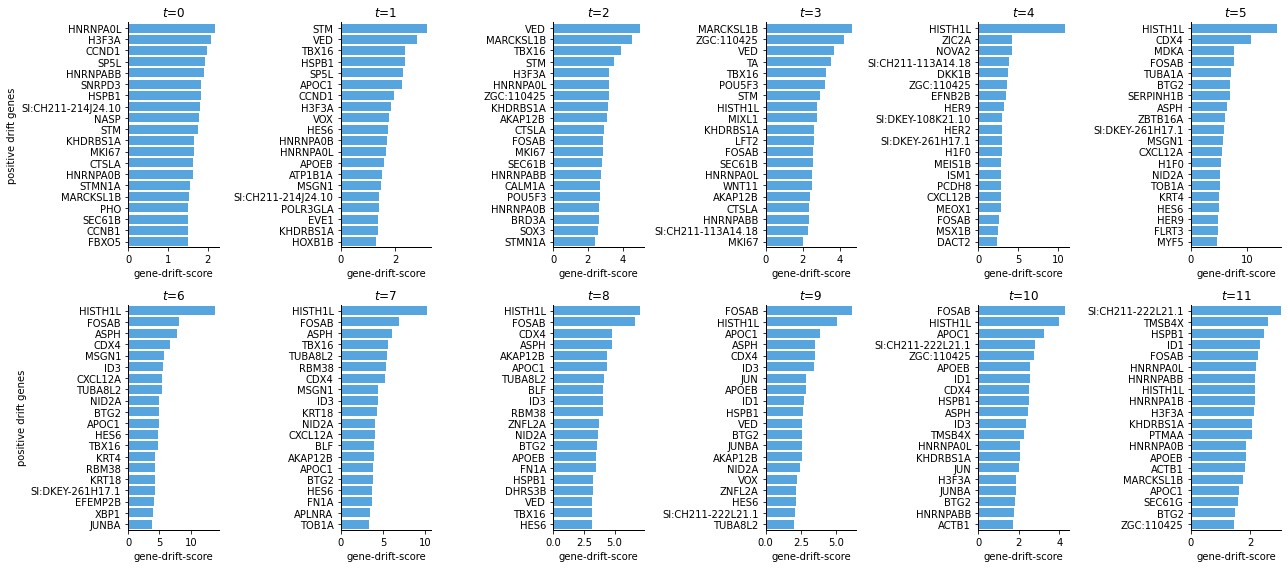

In [23]:
fig, axs = plt.subplots(2,6, figsize=(18, 8))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
i=0
for k,v in drift_genes.items():
    pos_drift_scores = v['pos'].to_frame()[:top_n]
    stage=timepoint_map[k]

    plt.margins(0, 0)
    axs[i].set_title(r'$t$'+f'={k}')
    pos_drift_scores["gene"] = pos_drift_scores.index
    pos_drift_scores.columns=["value","gene"]
    sns.barplot(data=pos_drift_scores, y="gene",x="value", orient="h", ax=axs[i], color="#3fa9f5")# palette="PuBu_r")
    axs[i].set_ylabel('')
    if i ==0 or i==6:
        axs[i].set_ylabel('positive drift genes')
    axs[i].set_xlabel('gene-drift-score')

    for spine in ['top', 'right', 'bottom', 'left']:
        axs[i].spines[spine].set_linewidth(1)
    axs[i].spines[['right', 'top']].set_visible(False)
    i+=1

plt.tight_layout()
# plt.savefig(f"{SAVE_PATH}/positive_drift_genes.png",dpi=300)
plt.show()

6. Get dead-live genes and differentially expressed genes between dead-live cells

In [22]:
def get_estimated_death_at_t(t, x_t, x_t_plus_1, status):


    params = tr.training_setup.state[1][FERRYMAN]
    eval_ferryman = partial(tr.training_setup.ferryman.apply, params=params, direction="forward")

    death_threshold = ts.sde.killer(t/train_dataset.steps_num, x_t)
    key, death_threshold = ts.sde.reweight_killing(random.PRNGKey(0), FORWARD, death_threshold, eval_ferryman, x_t, status, t/train_dataset.steps_num, x_t_plus_1)

    return death_threshold
def get_dead_cells(t, trajs, statuses, birth_statuses):

    dead_cells = []

    status_t = statuses[t]
    status_t_plus_1 = statuses[t+1]
    birth_status_t_plus_1 = birth_statuses[t+1]

    estimated_death_threshold = get_estimated_death_at_t(t, trajs[t], trajs[t+1], status_t)

    estimated_death_threshold_dead_cells=[]

    alive_t_idx = np.where(status_t)[0]
    dead_t_plus_1_idx= [] 
    for idx in alive_t_idx:
        if status_t[idx] & ~status_t_plus_1[idx]:
            dead_cells.append(trajs[t][idx])
            dead_t_plus_1_idx.append(idx)
            estimated_death_threshold_dead_cells.append(estimated_death_threshold[idx].item())
        elif birth_status_t_plus_1[idx].item() != 0:
            dead_cells.append(trajs[t][idx])
            dead_t_plus_1_idx.append(idx)
            estimated_death_threshold_dead_cells.append(estimated_death_threshold[idx].item())

    return dead_cells, estimated_death_threshold, estimated_death_threshold_dead_cells, dead_t_plus_1_idx

def get_split_cells(t, statuses, birth_statuses):

    split_cells=[]

    status_t = statuses[t]
    birth_status_t_plus_1 = birth_statuses[t+1]

    alive_t_idx = np.where(status_t)[0]

    for idx in alive_t_idx:
        birth_idx_t_plus_1 = np.where(birth_status_t_plus_1==idx)[0]
        if len(birth_idx_t_plus_1)==0:
            continue
        else:
            if idx == birth_idx_t_plus_1[0]:
                continue
            split_cells.append((idx, (idx,birth_idx_t_plus_1[0])))
    return split_cells

def get_reborn_cells(t, trajs, statuses, birth_statuses):
    print (t)

    reborn_cells=[]

    status_t = statuses[t]
    status_t_plus_1 = statuses[t+1]
    birth_status_t_plus_1 = birth_statuses[t+1]
    trajs_t_plus_1 = trajs[t+1]

    dead_to_alive = np.logical_and(~status_t, status_t_plus_1)

    dead_to_alive_t_plus_1_idx = np.where(dead_to_alive)[0]

    for idx in dead_to_alive_t_plus_1_idx:
        if birth_status_t_plus_1[idx]==0:
            reborn_cells.append(trajs_t_plus_1[idx])
    
    return reborn_cells

def cell_time_to_real_time(t):
    times_orig = train_dataset.times_orig
    t_real = (t*(times_orig[-1]-times_orig[0]))/train_dataset.steps_num + times_orig[0]
    return t_real

def get_reconstructed_dead_cells(pred_trajectories, val_data, vae_input_dim, vae_dec_hidden_dim, tr_model, timepoints):
    dec = hk.transform(lambda z: Decoder(output_shape=vae_input_dim, hidden_size=vae_dec_hidden_dim)(z))
    rng_seq = hk.PRNGSequence(1)
    dec_init_params = dec.init(next(rng_seq), z=np.zeros((val_data.shape[0], vae_latent_dim+8)))

    for key in tr_model.vae_params.keys():
        if "dec" in key:
            dec_init_params[key.split("~/")[1]] = tr_model.vae_params[key]
            
    t_emb = get_timestep_embedding(timepoints, 8)
    pred_traj_t = jnp.concatenate((pred_trajectories,t_emb),-1)

    recon_data = dec.apply(dec_init_params, None, pred_traj_t)
    recon_data.shape

    return recon_data

In [24]:
params = tr.training_setup.state[1]
eval_score = broadcast(lambda model, params: partial(tr.training_setup.score(model), params), tr.training_setup.model, params)
params_ferryman = tr_model.training_setup.state[1][FERRYMAN]
eval_ferryman= partial(tr_model.training_setup.ferryman.apply, params=params_ferryman, direction=FORWARD)

train_val_latent = pd.concat([train_latent, val_latent])
val_data_init = train_val_latent[train_val_latent["time"]==timepoints_sorted[0]].iloc[:,:-1].values

max_size=2000

if max_size!=0:
    val_data_init = sample(val_data_init, size = (max_size, ))

print (val_data_init.shape)
trajs, _, statuses, birth_statuses = ts.sde.sample_trajectory(random.PRNGKey(0), FORWARD, val_data_init, eval_score, 
                                                                eval_ferryman, corrector="",  test=False, max_size=max_size)

(2000, 10)


In [ ]:
cell_real_time_ordered=True

dead_cell_count = []
dead_cells_per_interval={}
interval_count=0
all_times = list(map(lambda t: int(train_dataset.cells_time(t)*train_dataset.steps_num), timepoints_sorted))

# Get dead cells in each in/media/sayali/External Dr/Sayali/UDSB/src_vae_fbsde/resultsv1.2/params/zebrafishterval defined by measured timepoints
print ("getting dead cells")
for t in tqdm(np.arange(0,train_dataset.steps_num)):#train_dataset.times:

    start_int = all_times[interval_count]
    end_int = all_times[interval_count+1]

    if t==0:
        interval_i=[]
    
    dead_cells, _, _, _ = get_dead_cells(t, trajs, statuses, birth_statuses)
    if len(dead_cells)!=0:
        dead_cells = np.stack(dead_cells)
        dead_cell_count.append(dead_cells.shape[0])

        if not cell_real_time_ordered:
            dead_cell_time = np.round(cell_time_to_real_time(np.array([t]*dead_cells.shape[0])))
        else:
            dead_cell_time = np.array([t]*dead_cells.shape[0])
            
        recon_dead_cells = get_reconstructed_dead_cells(dead_cells, val_data, vae_input_dim, vae_dec_hidden_dim, tr_model, dead_cell_time)      
        interval_i.extend(recon_dead_cells)

    if t+1 == end_int or t==train_dataset.steps_num:
        dead_cells_per_interval[f"{start_int}_{end_int}"] = interval_i
        interval_i=[]
        interval_count+=1

alive_cells_per_interval={}
interval_count=0
all_times = list(map(lambda t: int(train_dataset.cells_time(t)*train_dataset.steps_num), timepoints_sorted))

# Get live cells in each interval defined by measured timepoints
print ("getting live cells")
for t in tqdm(np.arange(0,train_dataset.steps_num+1)):

    start_int = all_times[interval_count]
    end_int = all_times[interval_count+1]

    if t==0:
        interval_i=[]

    alive_cells = trajs[t][statuses[t]]

    if not cell_real_time_ordered:
        alive_cell_time = np.round(cell_time_to_real_time(np.array([t]*alive_cells.shape[0])))
    else:
        alive_cell_time = np.array([t]*alive_cells.shape[0])

    recon_alive_cells = get_reconstructed_dead_cells(alive_cells, val_data, vae_input_dim, vae_dec_hidden_dim, tr_model, alive_cell_time)        
    interval_i.extend(recon_alive_cells)

    if t == end_int or t==train_dataset.steps_num:
        alive_cells_per_interval[f"{start_int}_{end_int}"] = interval_i
        interval_i=[]
        interval_count+=1

getting dead cells


  0%|          | 0/100 [00:00<?, ?it/s]

getting live cells


  0%|          | 0/101 [00:00<?, ?it/s]

In [30]:
# print (all_times,  train_dataset.times,)
for k,v in dead_cells_per_interval.items():
    print (k, len(v))

0_9 4
9_18 0
18_27 0
27_36 25
36_45 22
45_54 0
54_63 0
63_72 0
72_81 0
81_90 931
90_100 0


In [31]:
for k,v in alive_cells_per_interval.items():
    print (k, len(v))

0_9 783
9_18 1050
18_27 1765
27_36 1759
36_45 1519
45_54 2567
54_63 6569
63_72 10101
72_81 11022
81_90 5322
90_100 6573


In [32]:
gene_list = df.columns.to_list()[:-1]

In [35]:
# Load zebrafish developmental stage genes
# can be downloaded from: https://www.science.org/doi/10.1126/science.aar3131 
zb_genes=pd.read_excel("{DATA_PATH}/zebrafish_genes/aar3131_farrell_table-s2.xlsx", sheet_name="3 Somites")
death_genes = zb_genes["Module 26"].to_list()

birth_genes = zb_genes["Module 4"].to_list()
zb_genes_=pd.read_excel("{DATA_PATH}/aar3131_farrell_table-s2.xlsx", sheet_name="Bud")
birth_genes += zb_genes_["Module 7"].to_list()

In [ ]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# calculate DE genes
def get_de_genes(interval_i_cells, gene_list):
    # code adapted from: https://www.biostars.org/p/9495368/
    pvalues = []
    log_fold_changes = []
    for gene in gene_list:
        data = pd.concat([interval_i_cells[gene], interval_i_cells['status']], axis=1)
        data.columns = ['expression', 'condition']

        condition_1_expression = data.loc[data['condition'] == data['condition'].unique()[0], 'expression']
        condition_2_expression = data.loc[data['condition'] == data['condition'].unique()[1], 'expression']

        p = mannwhitneyu(condition_1_expression, condition_2_expression)[1]
        log_fold_change = np.log2((condition_2_expression.mean() + 1) / (condition_1_expression.mean() + 1))

        pvalues.append(p)
        log_fold_changes.append(log_fold_change)

    # adjust p-values using FDR
    fdr = multipletests(pvalues, method='fdr_bh')[1]

    # combine p-values, adjusted p-values and log fold changes into a DataFrame for easy viewing
    results = pd.DataFrame({
        'gene': gene_list,
        'p_value': pvalues,
        'fdr': fdr,
        'log_fold_change': log_fold_changes
    })
    return results

sample_alive_cells=True
for int_i in ['81_90']: #dead_cells_per_interval.keys():
    if len(dead_cells_per_interval[int_i])==0:
        continue

    interval_i_dead_df= pd.DataFrame(np.stack(dead_cells_per_interval[int_i]), columns=gene_list)
    genes_to_check = interval_i_dead_df.std().sort_values(ascending=False).index[:]
    interval_i_alive_df= pd.DataFrame(np.stack(alive_cells_per_interval[int_i]), columns=gene_list)
        
    if sample_alive_cells and len(interval_i_dead_df)<len(interval_i_alive_df):
        n=len(interval_i_dead_df)#100
        interval_i_alive_df= pd.DataFrame(np.stack(alive_cells_per_interval[int_i]), columns=gene_list).sample(n=n)

    interval_i_cells = pd.concat([interval_i_dead_df,interval_i_alive_df])
    interval_i_cells["status"] = ["dead"]*len(interval_i_dead_df) + ["live"]*len(interval_i_alive_df)

    interval_i_de_genes = get_de_genes(interval_i_cells, gene_list)

    top_de_genes = interval_i_de_genes.sort_values(by=["fdr"])["gene"].to_list()[:20]
    tmp_top_de_genes=interval_i_de_genes.sort_values(by=["fdr"])["gene"].to_list()[:1000]
    zb_death_genes = list(set(tmp_top_de_genes).intersection(set(death_genes)))
    zb_birth_genes = list(set(tmp_top_de_genes).intersection(set(birth_genes)))

    if len(zb_death_genes) == 0:
        interval_i_cells_w_de_genes = interval_i_cells[top_de_genes+["status"]]
    else:
        interval_i_cells_w_de_genes = interval_i_cells[zb_birth_genes + zb_death_genes+["status"]]
    interval_i_cells_w_de_genes = interval_i_cells_w_de_genes.melt("status")

In [37]:
interval_i_cells_w_de_genes_GO = interval_i_cells_w_de_genes[interval_i_cells_w_de_genes["variable"].isin(["ZGC:110425","ZGC:92242",'CCDC9'])]
interval_i_cells_w_de_genes_GO["GO_status"] = interval_i_cells_w_de_genes_GO["variable"].map({"ZGC:110425":"GO_alive",
                                                                                           "ZGC:92242":"GO_dead","CCDC9":"GO_dead"})
interval_i_cells_w_de_genes_GO.head()

,status,variable,value,GO_status
3724,dead,ZGC:110425,1.125662,GO_alive
3725,dead,ZGC:110425,0.884488,GO_alive
3726,dead,ZGC:110425,2.925428,GO_alive
3727,dead,ZGC:110425,2.292434,GO_alive
3728,dead,ZGC:110425,2.162995,GO_alive


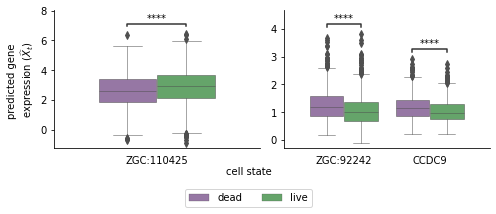

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (7,2.5))
subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=2)
states_palette = sns.color_palette("PRGn", n_colors=4)
i=0
for n,g in interval_i_cells_w_de_genes_GO.groupby("GO_status"):
    subgroup = g
    box_pairs=[]
    for gene_name in g["variable"].unique():
        box_pairs.append(((f"{gene_name}","dead"),(f"{gene_name}","live")))

    sns.boxplot(ax=axes[i],data=subgroup,x="variable", y='value', hue='status',palette=[states_palette[0],states_palette[-1]],linewidth=0.5,color="black",)
    test_results = add_stat_annotation(ax=axes[i],data=subgroup,x="variable", y='value', hue='status', 
                                            box_pairs=box_pairs,
                                            test='t-test_ind',#'Mann-Whitney', 
                                            text_format='star',
                                            loc='inside', verbose=0)
    # if i!=4:
    axes[i].get_legend().remove()
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].tick_params(bottom=False, left=True)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    i+=1

axes[0].set_ylabel("predicted gene \nexpression ("+r"$\widehat{X}_t$"+")")
fig.text(0.5, 0.01, 'cell state', ha='center',)
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',ncol=2, bbox_to_anchor=(0.5, -0.2))

plt.subplots_adjust(wspace=0.1, hspace=1)
plt.tight_layout()
# plt.savefig(f"{SAVE_PATH}/interval_9_10_groundtruth_enriched_cell_cycle_apoptosis_genes.png",
                # dpi=300, bbox_inches="tight")
plt.show()